### Import Packages

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

data_dir = "./bda2024_mid_dataset"

files = os.listdir(data_dir)
print("View all datasets:")
for f in files:
    print(f)

View all datasets:
bda2024_202203-202402_內容數據_新聞1.csv
bda2024_202203-202402_內容數據_新聞2.csv
bda2024_202203-202402_內容數據_新聞3.csv
bda2024_202203-202402_討論數據_dcard.csv
bda2024_202203-202402_討論數據_mobile01-1.csv
bda2024_202203-202402_討論數據_mobile01-2.csv
bda2024_202203-202402_討論數據_ptt.csv
bda2024_微股力_個股交易數據-2年.csv
bda2024_微股力_社群PKTD-2年.csv
bda2024_微股力_籌碼數據-2年.csv
bda2024_微股力_財報數據-2年.csv


### Import / Preprocess Data

In [2]:
news3_df = pd.read_csv("./bda2024_mid_dataset/bda2024_202203-202402_內容數據_新聞3.csv")

In [3]:
def check_contained_option(title, options):
    for option in options:
        if option in title:
            return option
    return None

#Find news
news3_df['stock_name'] = news3_df['title'].apply(check_contained_option, options = ["聯發科"])

In [4]:
news3_df
news3_df[news3_df["stock_name"] == "聯發科"].count()

id             979
p_type         979
s_name         979
s_area_name    979
post_time      979
title          979
author         863
content        979
page_url       979
stock_name     979
dtype: int64

In [5]:
transaction_df = pd.read_csv("./bda2024_mid_dataset/bda2024_微股力_個股交易數據-2年.csv")
report_df = pd.read_csv("./bda2024_mid_dataset/bda2024_微股力_財報數據-2年.csv")
chip_df = pd.read_csv("./bda2024_mid_dataset/bda2024_微股力_籌碼數據-2年.csv")
social_df = pd.read_csv("./bda2024_mid_dataset/bda2024_微股力_社群PKTD-2年.csv")
transaction_df['stock_symbol'] = transaction_df['stock_symbol'].astype(str)
chip_df['stock_symbol'] = chip_df['stock_symbol'].astype(str)    # Repair mixed data types

C:\Users\John8\AppData\Local\Temp\ipykernel_15888\271513545.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  transaction_df = pd.read_csv("./bda2024_mid_dataset/bda2024_微股力_個股交易數據-2年.csv")
C:\Users\John8\AppData\Local\Temp\ipykernel_15888\271513545.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  chip_df = pd.read_csv("./bda2024_mid_dataset/bda2024_微股力_籌碼數據-2年.csv")


In [6]:
transaction_df[transaction_df["stock_name"] == "聯發科"].sort_values(by=['date'])

,stock_name,stock_symbol,open,high,low,close,volume,date
60462,聯發科,2454,1105.0,1120.0,1095.0,1100.0,5544,2022-03-01 00:00:00
61191,聯發科,2454,1105.0,1105.0,1070.0,1080.0,3703,2022-03-02 00:00:00
61192,聯發科,2454,1085.0,1100.0,1065.0,1080.0,3873,2022-03-03 00:00:00
61193,聯發科,2454,1060.0,1060.0,1025.0,1025.0,6621,2022-03-04 00:00:00
61194,聯發科,2454,985.0,995.0,970.0,972.0,11349,2022-03-07 00:00:00
...,...,...,...,...,...,...,...,...
1074519,聯發科,2454,960.0,985.0,960.0,982.0,8929,2024-02-20 00:00:00
1071064,聯發科,2454,972.0,986.0,972.0,981.0,5895,2024-02-21 00:00:00
1073582,聯發科,2454,988.0,1020.0,988.0,1015.0,11143,2024-02-22 00:00:00
1071199,聯發科,2454,1035.0,1100.0,1010.0,1100.0,24851,2024-02-23 00:00:00


### News categorizing

In [7]:
def get_next_date(input_date, dates_list):
    index = sum(1 for d in dates_list if d < input_date)
    if index >= len(dates_list):
        return -1, -1
    else:
        return index, dates_list[index]

def get_answer(stock_name, input_date, n_days_after, threshold):
    dates_list = sorted(transaction_df.loc[(transaction_df['stock_name']==stock_name)]['date'])
    i, _ = get_next_date(input_date, dates_list)

    if i == -1 or i >= len(dates_list) or i + n_days_after >= len(dates_list):
        return 2
    
    open_date = dates_list[i]
    close_date = dates_list[i + n_days_after]
    
    
    open_price = transaction_df.loc[(transaction_df['date']==open_date) & (transaction_df['stock_name']==stock_name)]['open'].iloc[0]
    close_price = transaction_df.loc[(transaction_df['date']==close_date) & (transaction_df['stock_name']==stock_name)]['close'].iloc[0]
    price_change = (close_price - open_price) / open_price
    print(f"{stock_name:5} | {price_change:5.2f} (Open: {open_date}, {open_price} | Close: {close_date}, {close_price})")

    if price_change >= threshold:
        return 1     # buy
    elif price_change <= -threshold:
        return -1    # sell
    else:
        return 0     # hold

In [8]:
get_answer("聯發科", "2022-12-02", 5, 0.05)

聯發科   | -0.00 (Open: 2022-12-02 00:00:00, 730.0 | Close: 2022-12-09 00:00:00, 729.0)


0

In [9]:
newsSet = news3_df[news3_df["stock_name"] == "聯發科"]

In [10]:
newsSet['category'] = newsSet.apply(lambda r: get_answer(r['stock_name'], r['post_time'], 10, 0.05), axis = 1)

聯發科   | -0.10 (Open: 2022-12-02 00:00:00, 730.0 | Close: 2022-12-16 00:00:00, 660.0)
聯發科   | -0.10 (Open: 2022-12-02 00:00:00, 730.0 | Close: 2022-12-16 00:00:00, 660.0)
聯發科   | -0.11 (Open: 2022-12-05 00:00:00, 739.0 | Close: 2022-12-19 00:00:00, 656.0)
聯發科   | -0.09 (Open: 2022-12-08 00:00:00, 724.0 | Close: 2022-12-22 00:00:00, 661.0)
聯發科   | -0.08 (Open: 2022-12-09 00:00:00, 714.0 | Close: 2022-12-23 00:00:00, 660.0)
聯發科   | -0.08 (Open: 2022-12-09 00:00:00, 714.0 | Close: 2022-12-23 00:00:00, 660.0)
聯發科   | -0.08 (Open: 2022-12-09 00:00:00, 714.0 | Close: 2022-12-23 00:00:00, 660.0)
聯發科   | -0.08 (Open: 2022-12-09 00:00:00, 714.0 | Close: 2022-12-23 00:00:00, 660.0)
聯發科   | -0.08 (Open: 2022-12-09 00:00:00, 714.0 | Close: 2022-12-23 00:00:00, 660.0)
聯發科   | -0.08 (Open: 2022-12-09 00:00:00, 714.0 | Close: 2022-12-23 00:00:00, 660.0)
聯發科   | -0.08 (Open: 2022-12-09 00:00:00, 714.0 | Close: 2022-12-23 00:00:00, 660.0)
聯發科   | -0.08 (Open: 2022-12-09 00:00:00, 714.0 | Close: 2022-12-

C:\Users\John8\AppData\Local\Temp\ipykernel_15888\3201731397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newsSet['category'] = newsSet.apply(lambda r: get_answer(r['stock_name'], r['post_time'], 10, 0.05), axis = 1)


In [11]:
newsSet.head()

,id,p_type,s_name,s_area_name,post_time,title,author,content,page_url,stock_name,category
424,1669876841341_YahooStock,news,Yahoo股市,財經新聞,2022-12-01 14:38:45.000,ETF／富邦未來車(00895)調整4檔成分股 新列聯發科、LG新能源,李瑞瑾·Yahoo財經特派記者,富邦投信公告，富邦未來車ETF（00895）追蹤指數於2022年11月30日美國股市收盤後新...,https://tw.stock.yahoo.com/news/%E5%AF%8C%E9%8...,聯發科,-1
628,1669889886309_YahooStock,news,Yahoo股市,財經新聞,2022-12-01 18:03:00.000,【公告】聯發科設置資訊安全長,中央社,日 期：2022年12月01日公司名稱：聯發科 (2454)主 旨：聯發科設置資訊安全長發言...,https://tw.stock.yahoo.com/news/%E5%85%AC%E5%9...,聯發科,-1
1053,1669964139285_YahooStock,news,Yahoo股市,財經新聞,2022-12-02 14:41:43.000,國泰永續高股息成分股新增聯發科、瑞昱與中鋼,中央社,（中央社記者韓婷婷台北2022年12月2日電）國泰永續高股息ETF（00878）宣布，11月...,https://tw.stock.yahoo.com/news/%E5%9C%8B%E6%B...,聯發科,-1
4201,1670415965870_YahooStock,news,Yahoo股市,財經新聞,2022-12-07 19:17:58.000,是德 獲聯發科導入5G網路模擬器解決方案,蘇嘉維／台北報導,是德科技（Keysight Technologies Inc.）宣布聯發科技（2454）選用...,https://tw.stock.yahoo.com/news/%E6%98%AF%E5%B...,聯發科,-1
4648,1670467251576_YahooStock,news,Yahoo股市,財經新聞,2022-12-08 10:30:51.000,《盤中解析》台股跟跌台積電、聯發科 Q4指數打底、7大族群可留意,NaN,【時報記者莊丙農台北報導】烏俄核戰風險升高、美債殖利率曲線倒掛惡化等因素，美股四大指數小跌作...,https://tw.stock.yahoo.com/news/%E7%9B%A4%E4%B...,聯發科,-1


In [12]:
newsSet[newsSet['category'] == -1].count()

id             113
p_type         113
s_name         113
s_area_name    113
post_time      113
title          113
author          98
content        113
page_url       113
stock_name     113
category       113
dtype: int64

### Taking feature keywords

In [13]:
import monpa
from monpa import utils
from collections import Counter
import math

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


In [14]:
upSet = newsSet[newsSet['category'] == 1]
downSet = newsSet[newsSet['category'] == -1]

#### tf-idf calculation

In [15]:
up_tf_counter=Counter()
up_df_counter=Counter()

for index, row in upSet.iterrows():
    query = row['title'] + ' ' + row['content']
    df_tmp = Counter()
    sentence_list = utils.short_sentence(query)

    for item in sentence_list:
      result_cut = monpa.cut(item) 
      for term in result_cut:
        term = term.strip()
        if (len(term) > 1):
          up_tf_counter[term] += 1 
          if(df_tmp[term] == 0): 
            df_tmp[term] = 1 
    up_df_counter += df_tmp

KeyboardInterrupt: 

In [ ]:
down_tf_counter=Counter()
down_df_counter=Counter()

for index, row in downSet.iterrows():
    query = row['title'] + ' ' + row['content']
    df_tmp = Counter()
    sentence_list = utils.short_sentence(query)

    for item in sentence_list:
      result_cut = monpa.cut(item) 
      for term in result_cut:
        term = term.strip()
        if (len(term) > 1):
          down_tf_counter[term] += 1 
          if(df_tmp[term] == 0): 
            df_tmp[term] = 1 
    down_df_counter += df_tmp

In [ ]:
up_tf_idf = {}
d = len(upSet)
for term, freq in up_tf_counter.items():
    up_tf_idf[term] = freq * math.log(d / up_tf_counter[term])

In [ ]:
down_tf_idf = {}
d = len(downSet)
for term, freq in down_tf_counter.items():
    down_tf_idf[term] = freq * math.log(d / down_tf_counter[term])

In [ ]:
up_tf_idf
sorted(up_tf_idf.items(), key=lambda x: x[1], reverse=True)

In [ ]:
down_tf_idf
sorted(down_tf_idf.items(), key=lambda x: x[1], reverse=True)

#### Likelihood Ratio selection

In [16]:
frames = [upSet, downSet]
fullSet = pd.concat(frames).sort_values('post_time').reset_index()
fullSet.head()

,index,id,p_type,s_name,s_area_name,post_time,title,author,content,page_url,stock_name,category
0,424,1669876841341_YahooStock,news,Yahoo股市,財經新聞,2022-12-01 14:38:45.000,ETF／富邦未來車(00895)調整4檔成分股 新列聯發科、LG新能源,李瑞瑾·Yahoo財經特派記者,富邦投信公告，富邦未來車ETF（00895）追蹤指數於2022年11月30日美國股市收盤後新...,https://tw.stock.yahoo.com/news/%E5%AF%8C%E9%8...,聯發科,-1
1,628,1669889886309_YahooStock,news,Yahoo股市,財經新聞,2022-12-01 18:03:00.000,【公告】聯發科設置資訊安全長,中央社,日 期：2022年12月01日公司名稱：聯發科 (2454)主 旨：聯發科設置資訊安全長發言...,https://tw.stock.yahoo.com/news/%E5%85%AC%E5%9...,聯發科,-1
2,1053,1669964139285_YahooStock,news,Yahoo股市,財經新聞,2022-12-02 14:41:43.000,國泰永續高股息成分股新增聯發科、瑞昱與中鋼,中央社,（中央社記者韓婷婷台北2022年12月2日電）國泰永續高股息ETF（00878）宣布，11月...,https://tw.stock.yahoo.com/news/%E5%9C%8B%E6%B...,聯發科,-1
3,4201,1670415965870_YahooStock,news,Yahoo股市,財經新聞,2022-12-07 19:17:58.000,是德 獲聯發科導入5G網路模擬器解決方案,蘇嘉維／台北報導,是德科技（Keysight Technologies Inc.）宣布聯發科技（2454）選用...,https://tw.stock.yahoo.com/news/%E6%98%AF%E5%B...,聯發科,-1
4,4648,1670467251576_YahooStock,news,Yahoo股市,財經新聞,2022-12-08 10:30:51.000,《盤中解析》台股跟跌台積電、聯發科 Q4指數打底、7大族群可留意,NaN,【時報記者莊丙農台北報導】烏俄核戰風險升高、美債殖利率曲線倒掛惡化等因素，美股四大指數小跌作...,https://tw.stock.yahoo.com/news/%E7%9B%A4%E4%B...,聯發科,-1


In [17]:
import re
def clearSentence(sentence):
    return re.sub(r'[^\u4e00-\u9fa5]+', '', sentence)

In [18]:
## Calculate document freq of whole set
def cal_dict_docs(docsFrame):
  df_counter=Counter()

  for index, row in docsFrame.iterrows():
      query = row['title'] + ' ' + row['content']
      df_tmp = Counter()
      sentence_list = utils.short_sentence(query)

      for item in sentence_list:
        item = clearSentence(item)
        result_cut = monpa.cut(item) 
        for term in result_cut:
          term = term.strip()
          if (len(term) > 1):
            if(df_tmp[term] == 0): 
              df_tmp[term] = 1 
      df_counter += df_tmp
  return df_counter

In [20]:
## Calculate term freq for a document (a row)
def cal_term_docs(docsRow):
  tf_counter=Counter()

  for index, row in docsRow.iterrows():
      query = row['title'] + ' ' + row['content']
      sentence_list = utils.short_sentence(query)
      
      for item in sentence_list:
        item = clearSentence(item)
        result_cut = monpa.cut(item) 
        for term in result_cut:
          term = term.strip()
          if (len(term) > 1):
            tf_counter[term]+=1
  return tf_counter

In [21]:
def likeliratio_selection(docsFrame, trainCateg=[], nFeatrues=500):
    tfDocsList = {}
    vocabDict = cal_dict_docs(docsFrame)
    ScoreList = {}
        
    for i in range(len(docsFrame)):
        tfDocsList[i] = cal_term_docs(docsFrame.loc[[i]])
        
    for term in vocabDict:
        Score = 0
        for categ in trainCateg:
            real = np.zeros((2,2))
            for index, row in docsFrame.iterrows():
                if (row['category'] == trainCateg[categ]):
                    if (term in tfDocsList[index]):
                        real[0][0] += 1
                    else:
                        real[0][1] += 1
                else:
                    if (term in tfDocsList[index]):
                        real[1][0] += 1
                    else:
                        real[1][1] += 1
            sumTotal = real.sum()
            pt = (real[0][0] + real[1][0]) / sumTotal
            p1 = real[0][0] / (real[0][0] + real[0][1])
            p2 = real[1][0] / (real[1][0] + real[1][1])
            lambdaVal = ((pt ** real[0][0]) * ((1 - pt) ** real[0][1]) * (pt ** real[1][0]) * ((1 - pt) ** real[1][1])) / ((p1 ** real[0][0]) * ((1 - p1) ** real[0][1]) * (p2 ** real[1][0]) * ((1 - p2) ** real[1][1]))
            Score += -2 * math.log(lambdaVal)
        ScoreList[term] = Score
    selected = sorted(ScoreList, key=ScoreList.get, reverse=True)[:nFeatrues]
    totalList = sorted(ScoreList, key=ScoreList.get, reverse=True)
    return selected, totalList

In [22]:
result_keywords, total_keywords = likeliratio_selection(fullSet, trainCateg = [1, -1], nFeatrues = 1000)

In [23]:
result_keywords

['打造',
 '頒獎',
 '任何',
 '潘文淵獎',
 '改善',
 '季增',
 '採用',
 '使用者',
 '獲獎',
 '年初',
 '產品',
 '宣布',
 '定案',
 '架構',
 '量產',
 '協議',
 '首獎',
 '著重',
 '偏鄉',
 '機上盒',
 '提起',
 '指控',
 '發動',
 '成式',
 '水位',
 '說明會',
 '個位數',
 '合作',
 '近年',
 '訴訟',
 '原先',
 '一定',
 '通路',
 '大關',
 '運算',
 '語言',
 '天數',
 '不管',
 '辛苦',
 '憑證',
 '衝上',
 '加州',
 '控告',
 '司法',
 '手機',
 '平台',
 '時間',
 '好轉',
 '副總經理',
 '領先',
 '降至',
 '縮短',
 '有線',
 '存貨',
 '鴻海',
 '運行',
 '擴張',
 '提供',
 '毛利率',
 '過程',
 '家鄉',
 '專利',
 '宏碁',
 '旗艦',
 '台灣',
 '整合',
 '陳冠州',
 '成績',
 '研調',
 '上市',
 '先進',
 '分點',
 '地標',
 '辦公',
 '經理人',
 '曲線',
 '電訊',
 '聯發科智',
 '醫師',
 '學童',
 '口腔',
 '學校',
 '覺得',
 '課程',
 '獎勵',
 '仍舊',
 '半導體業',
 '授權金',
 '開花',
 '締造',
 '公平',
 '方便',
 '中華電信',
 '年生成式',
 '年生',
 '淨利',
 '強化',
 '展現',
 '降低',
 '預計',
 '方案',
 '名單',
 '培養',
 '千金股',
 '持續',
 '奈米',
 '挑戰',
 '裝置',
 '獨特',
 '單元',
 '開工',
 '優化',
 '健康',
 '經濟',
 '市場',
 '首度',
 '獎金',
 '但是',
 '引擎',
 '展示',
 '品質',
 '資深',
 '第一',
 '速度',
 '組合',
 '第五',
 '鼓勵',
 '製程',
 '投信',
 '持有',
 '資源',
 '千金',
 '降價',
 '上升',
 '謹慎',
 '藍牙',
 '利益率',
 '宣佈',
 '進軍',
 '雙位數

In [ ]:
result_keywords = total_keywords[:1000]

### Rq2: Categorizing model

In [27]:
import datetime
fullSet['post_time'] = pd.to_datetime(fullSet['post_time']).dt.date

#### Training Set Prepare

In [32]:
train_startDate = datetime.date(2023,1,1)
train_endDate = datetime.date(2023,9,30)

train_tokenStr_list = []

for i in list(fullSet[fullSet['post_time'].between(train_startDate, train_endDate)].index):
    try:
        sentence_list = utils.short_sentence(fullSet['content'][i])
        tokenStr = str()
        for sentence in sentence_list:
            sentence = clearSentence(sentence)
            tokens = monpa.cut(sentence)
            tokenStr += ' '.join(tokens)
        train_tokenStr_list.append(tokenStr)
    except:
        train_tokenStr_list.append('')

In [31]:
fullSet[fullSet['post_time'].between(train_startDate, train_endDate)]['category'].value_counts()

category
 1    77
-1    39
Name: count, dtype: int64

In [33]:
train_tokenStr_list

['財訊 快報 記者 李純君 報導 手機 晶片 大廠 聯發科 積極 佈局 物聯網 平台 宣布 自家 推出 的 智慧物 聯網 平台 採用 台 積電 奈米 製程 產出 並 將 在 年 第二季度 開始 商用聯發科 的 智慧物 聯網 平台 整合 高性能 八核 適用 於 智慧 家庭 智慧 零售 和 工業物 聯網 產品 而 聯發科 也 將 於 消費 電子展 期間 展示 最 新 的 應用 期盼 能 滿足 智慧 裝置 對 高速 算力 和 物 聯網 品質 的 需求 該 平台 預計 年 第二 季度 開始 商用以 台積電 奈米 製程 產出 的 其 八 核 包括 個主 頻 為 的 核心 與 個主 頻 為 的 核心 整合 的 加速器 可 提供 強勁 性能 此外 還 同時 支援 和 顯示 整合 影像 訊號 處理器 提供 更 出色 的 影像 畫質聯發科 智聯網事業部 副總經理 表示 去年 聯發科 發佈 了 智慧物 聯網 平台 提供 品牌 廠商 規模 拓展 及 產品 開發 支援 為 的 發展 奠定 了 堅實 的 基礎 而 這 次 的 是 為 工業 和 智慧 家庭 產品 而 生可 豐富 聯發科 的 智慧物 聯網 產品 組合軟體 開發 套件 支援 及 作業 系統 還 可以 支援 多 種 高速 介面 包括 和 相機 鏡頭 介面 以及 支持 和 顯示 支援 和 影像 解碼 並 適用於 工業級 設計 和 寬溫 設計 耐用 期限 長達 年同時 提供 標準 易 用 的 開源 平台 整合 解決 方案',
 '時報 記者 王逸芯 台北 報導 有 研調 機構 看好 在 建設 起飛 以及 低價 手機 市占率 拉升 下 印度 智慧型 手機 將 在 今年 底 出現 和 的 黃金 交叉 由於 印度 為 非 蘋 陣營 的 兵家 必爭 武林 儘管 各 大 品牌 拚 比較 勁 但 身為 晶片 大廠 的 聯發科 高通 都 將 受惠 只 是 未來 其 和 高通 在 價格 上 的 競爭 將 成 一 大 關鍵印度 被 全球 市場 看好 將 成為 繼 大陸 後 全球 對 最 大 消費型 電子 市場 尤其 在 智慧型 手機 上 因為 大陸 在 大規模 解封 後 疫情 風險 急速 攀升 今年 消費 市場 變數 相當 大 經濟 前景 備受 考驗 加上 大陸 智慧機 市場 也 已經 逐步 進入 成長 高 原期 故 印度 也 被 各 個 手機 大廠 

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
with open('./stopwords_zh.txt', 'r') as file:
    stopwords = file.read().splitlines()
file.close()

In [36]:
#Training set vectorizaiton
vectorizer = TfidfVectorizer(stop_words=stopwords)
y_train = fullSet[fullSet['post_time'].between(train_startDate, train_endDate)]['category']

X_train = vectorizer.fit_transform(train_tokenStr_list)
X_train = pd.DataFrame(X_train.toarray(),columns=vectorizer.get_feature_names_out())
X_train[[col for col in X_train.columns if col in result_keywords]]

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lex', '①①', '①②', '①③', '①④', '①⑤', '①⑥', '①⑦', '①⑧', '①⑨', '①ａ', '①ｂ', '①ｃ', '①ｄ', '①ｅ', '①ｆ', '①ｇ', '①ｈ', '①ｉ', '①ｏ', '②①', '②②', '②③', '②④', '②⑤', '②⑥', '②⑦', '②⑧', '②⑩', '②ａ', '②ｂ', '②ｄ', '②ｅ', '②ｆ', '②ｇ', '②ｈ', '②ｉ', '②ｊ', '③①', '③⑩', '③ａ', '③ｂ', '③ｃ', '③ｄ', '③ｅ', '③ｆ', '③ｇ', '③ｈ', '④ａ', '④ｂ', '④ｃ', '④ｄ', '④ｅ', '⑤ａ', '⑤ｂ', '⑤ｄ', '⑤ｅ', '⑤ｆ', '１２', 'ｌｉ', 'ｚｘｆｉｔｌ'] not in stop_words.
  warnings.warn(


,一併,一線,一覽表,一路,上市,上百,上看,上萬,下半年,不容,...,驚豔,高峰,高通聯發科,高速,高階,魏哲家,鴻海,黃仁勳,黃合淇,鼓勵
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.117023,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.067049,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.082960,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.052721,0.0,...,0.0,0.0,0.000000,0.066910,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.038143,0.068432,0.0,0.000000,0.0,0.0,0.0
140,0.0,0.0,0.0,0.0,0.033458,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.043010,0.038583,0.0,0.000000,0.0,0.0,0.0
141,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.022164,0.0,0.034698,0.0,0.0,0.0
142,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.072988,0.0,0.000000,0.0,0.0,0.0


In [37]:
#LLR Feature selection
X_trainN = pd.DataFrame(index=range(0,len(X_train)), columns=result_keywords).fillna(0)
X_trainN[[col for col in X_train.columns if col in result_keywords]] = X_train[[col for col in X_train.columns if col in result_keywords]]
X_trainN

,打造,頒獎,任何,潘文淵獎,改善,季增,採用,使用者,獲獎,年初,...,首日,漲多,一線,賣出,有力,心態,立場,溝通,審慎,昨日
0,0.000000,0,0,0,0.000000,0.0,0.038452,0.0,0,0.0,...,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0,0,0,0.000000,0.0,0.000000,0.0,0,0.0,...,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
2,0.054133,0,0,0,0.000000,0.0,0.043971,0.0,0,0.0,...,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0,0,0,0.000000,0.0,0.000000,0.0,0,0.0,...,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0,0,0,0.000000,0.0,0.000000,0.0,0,0.0,...,0.104542,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.000000,0,0,0,0.034786,0.0,0.050133,0.0,0,0.0,...,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
140,0.000000,0,0,0,0.000000,0.0,0.113061,0.0,0,0.0,...,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
141,0.000000,0,0,0,0.000000,0.0,0.000000,0.0,0,0.0,...,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
142,0.000000,0,0,0,0.000000,0.0,0.000000,0.0,0,0.0,...,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#chi2 feature selection
chi2_selector = SelectKBest(chi2, k = 500)
chi2_selector.fit(X_train, y_train)
kbest_vocabs = X_train.columns[chi2_selector.get_support()]
X_trainchi = X_train[kbest_vocabs]
X_trainchi.head()

,一季,一定,一百一十一年,一線,三星,上周,上行,下半年,下游,不分,...,頻率,頻譜,首度,首獎,香港,騷擾,高通,高階,高雄,鼓勵
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Testing Set Prepare

In [38]:
test_startDate = datetime.date(2023,10,1)
test_endDate = datetime.date(2023,12,31)

test_tokenStr_list = []

for i in list(fullSet[fullSet['post_time'].between(test_startDate, test_endDate)].index):
    try:
        sentence_list = utils.short_sentence(fullSet['content'][i])
        tokenStr = str()
        for sentence in sentence_list:
            sentence = clearSentence(sentence)
            tokens = monpa.cut(sentence)
            tokenStr += ' '.join(tokens)
        test_tokenStr_list.append(tokenStr)
    except:
        test_tokenStr_list.append('')

In [39]:
y_test = fullSet[fullSet['post_time'].between(test_startDate, test_endDate)]['category']

vectorizer = TfidfVectorizer(stop_words=stopwords)
X_test = vectorizer.fit_transform(test_tokenStr_list)
X_test = pd.DataFrame(X_test.toarray(),columns=vectorizer.get_feature_names_out())

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lex', '①①', '①②', '①③', '①④', '①⑤', '①⑥', '①⑦', '①⑧', '①⑨', '①ａ', '①ｂ', '①ｃ', '①ｄ', '①ｅ', '①ｆ', '①ｇ', '①ｈ', '①ｉ', '①ｏ', '②①', '②②', '②③', '②④', '②⑤', '②⑥', '②⑦', '②⑧', '②⑩', '②ａ', '②ｂ', '②ｄ', '②ｅ', '②ｆ', '②ｇ', '②ｈ', '②ｉ', '②ｊ', '③①', '③⑩', '③ａ', '③ｂ', '③ｃ', '③ｄ', '③ｅ', '③ｆ', '③ｇ', '③ｈ', '④ａ', '④ｂ', '④ｃ', '④ｄ', '④ｅ', '⑤ａ', '⑤ｂ', '⑤ｄ', '⑤ｅ', '⑤ｆ', '１２', 'ｌｉ', 'ｚｘｆｉｔｌ'] not in stop_words.
  warnings.warn(


In [40]:
#LLR Feature selection
X_testN = pd.DataFrame(index=range(0,len(X_test)), columns=result_keywords).fillna(0)
X_testN[[col for col in X_test.columns if col in result_keywords]] = X_test[[col for col in X_test.columns if col in result_keywords]]

In [ ]:
#chi2 feature selection
vectorizer = TfidfVectorizer(stop_words=stopwords)
X_testchi = X_test.reindex(kbest_vocabs, axis=1, fill_value=0)
X_testchi.head()

,一季,一定,一百一十一年,一線,三星,上周,上行,下半年,下游,不分,...,頻率,頻譜,首度,首獎,香港,騷擾,高通,高階,高雄,鼓勵
0,0.0,0.0,0,0.0,0.0,0,0,0.000000,0.0,0,...,0,0,0.0,0,0.0,0,0.000000,0.026508,0.0,0.0
1,0.0,0.0,0,0.0,0.0,0,0,0.041494,0.0,0,...,0,0,0.0,0,0.0,0,0.070444,0.000000,0.0,0.0
2,0.0,0.0,0,0.0,0.0,0,0,0.050778,0.0,0,...,0,0,0.0,0,0.0,0,0.086206,0.000000,0.0,0.0
3,0.0,0.0,0,0.0,0.0,0,0,0.000000,0.0,0,...,0,0,0.0,0,0.0,0,0.106938,0.000000,0.0,0.0
4,0.0,0.0,0,0.0,0.0,0,0,0.000000,0.0,0,...,0,0,0.0,0,0.0,0,0.000000,0.000000,0.0,0.0


#### Training model and test model

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

##### GDBoost

In [45]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=5, random_state=0)
clf.fit(X_trainN, y_train)
clf.score(X_trainN, y_train)

0.9791666666666666

In [46]:
accuracy_score(y_test, clf.predict(X_testN))

0.7068965517241379

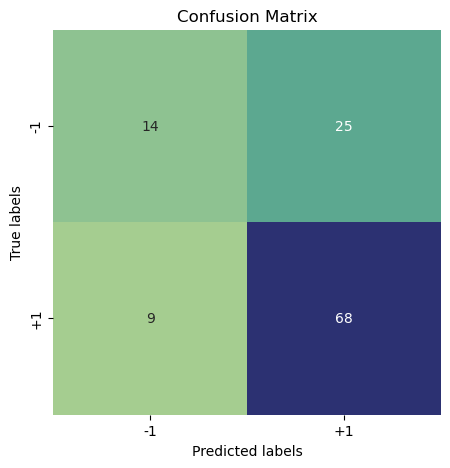

In [47]:
cm = confusion_matrix(y_test, clf.predict(X_testN))
class_labels = ['-1', '+1']

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap="crest", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

##### SVC

In [48]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_trainN, y_train)
clf.score(X_trainN, y_train)

0.9027777777777778

In [49]:
accuracy_score(y_test, clf.predict(X_testN))

0.6896551724137931

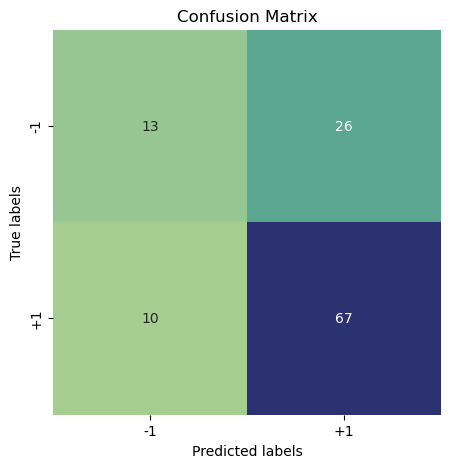

In [50]:
cm = confusion_matrix(y_test, clf.predict(X_testN))
class_labels = ['-1', '+1']

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap="crest", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

##### Random Forest

In [91]:
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_trainN, y_train)
clf.score(X_trainN, y_train)

0.8402777777777778

In [92]:
accuracy_score(y_test, clf.predict(X_testN))

0.6637931034482759

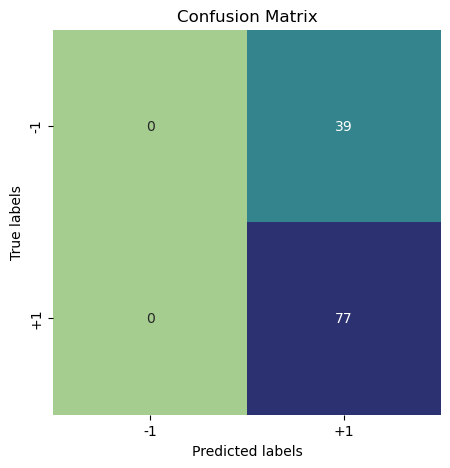

In [93]:
cm = confusion_matrix(y_test, clf.predict(X_testN))
class_labels = ['-1', '+1']

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap="crest", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

##### MLP

In [88]:
model = MLPClassifier(hidden_layer_sizes=(500, 50), max_iter=300)
model.fit(X_trainN, y_train)
y_test_pred = model.predict(X_testN)

accuracy = accuracy_score(y_test, y_test_pred)

In [89]:
accuracy

0.7413793103448276

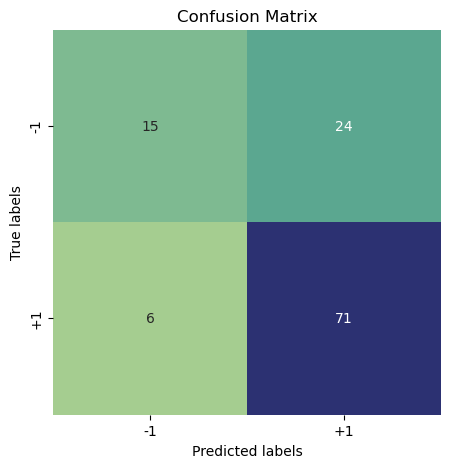

In [90]:
cm = confusion_matrix(y_test, y_test_pred)
class_labels = ['-1', '+1']

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap="crest", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

### Rq3: Cross-validation (Subset)

In [ ]:
import datetime
from tqdm import tqdm
from dateutil.relativedelta import relativedelta

newsSet = pd.read_csv('./newsSet.csv')
newsSet['post_time'] = pd.to_datetime(newsSet['post_time']).dt.date
fullSet = newsSet.drop(newsSet[newsSet['category'] == 2].index)
fullSet['post_time'] = pd.to_datetime(fullSet['post_time']).dt.date

for i in tqdm(range(0, 1), desc ="Trainning on month x"):
    #Training using 3 months data
    train_startDate = datetime.date(2022,11,1) + relativedelta(months=i)
    train_endDate = datetime.date(2023,1,31) + relativedelta(months=i)
    trainList = fullSet[fullSet['post_time'].between(train_startDate, train_endDate)]
    train_tokenStr_list = []

    for i in list(fullSet[fullSet['post_time'].between(train_startDate, train_endDate)].index):
        try:
            sentence_list = utils.short_sentence(fullSet['content'][i])
            tokenStr = str()
            for sentence in sentence_list:
                sentence = clearSentence(sentence)
                tokens = monpa.cut(sentence)
                tokenStr += ' '.join(tokens)
            train_tokenStr_list.append(tokenStr)
        except:
            train_tokenStr_list.append('')

    vectorizer = TfidfVectorizer(stop_words=stopwords)
    y_train = fullSet[fullSet['post_time'].between(train_startDate, train_endDate)]['category']
    X_train = vectorizer.fit_transform(train_tokenStr_list)
    X_train = pd.DataFrame(X_train.toarray(),columns=vectorizer.get_feature_names_out())

    chi2_selector = SelectKBest(chi2, k = 1000)
    chi2_selector.fit(X_train, y_train)
    kbest_vocabs = X_train.columns[chi2_selector.get_support()]
    X_train = X_train[kbest_vocabs]

    model = MLPClassifier(hidden_layer_sizes=(500, 50), max_iter=300)
    model.fit(X_train, y_train)

    #Testing using 3 + 1 month data
    dateList = []
    resultList = []
    for i in tqdm(range(1, 32), desc ="Testing on month x day y:"):
        test_startDate = train_endDate + timedelta(days=i)
        test_endDate = train_endDate + timedelta(days=i+1)

        test_tokenStr_list = []
        for i in list(newsSet[newsSet['post_time'].between(test_startDate, test_endDate)].index):
            try:
                sentence_list = utils.short_sentence(newsSet['content'][i])
                tokenStr = str()
                for sentence in sentence_list:
                    sentence = clearSentence(sentence)
                    tokens = monpa.cut(sentence)
                    tokenStr += ' '.join(tokens)
                test_tokenStr_list.append(tokenStr)
            except:
                test_tokenStr_list.append('')
        print(test_tokenStr_list)
        vectorizer = TfidfVectorizer(stop_words=stopwords)
        try:
          X_test = vectorizer.fit_transform(test_tokenStr_list)
          X_test = pd.DataFrame(X_test.toarray(),columns=vectorizer.get_feature_names_out())
          X_test = X_test.reindex(kbest_vocabs, axis=1, fill_value=0)

          y_pred = model.predict(X_test)
          price_change_pred = 1 if sum(y_pred) > 0 else 0 if sum(y_pred) == 0 else -1
        except:
          price_change_pred = 0
        dateString = test_startDate.strftime("%Y/%m/%d")
        dateList.append(dateString)
        resultList.append(price_change_pred)
    df = pd.DataFrame(list(zip(dateList, resultList)),columns =['date', 'result'])
    df.to_csv('./result.csv')